In [1]:
from datasets import load_dataset

In [2]:
dataset_train = load_dataset('unsloth/LaTeX_OCR', split='train[:3000]')

README.md:   0%|          | 0.00/519 [00:00<?, ?B/s]

data/train-00000-of-00001.parquet:   0%|          | 0.00/344M [00:00<?, ?B/s]

data/test-00000-of-00001.parquet:   0%|          | 0.00/38.2M [00:00<?, ?B/s]

Generating train split:   0%|          | 0/68686 [00:00<?, ? examples/s]

Generating test split:   0%|          | 0/7632 [00:00<?, ? examples/s]

In [3]:
dataset_train

Dataset({
    features: ['image', 'text'],
    num_rows: 3000
})

In [11]:
import matplotlib.pyplot as plt
from tqdm import tqdm

{ \frac { N } { M } } \in { \bf Z } , { \frac { M } { P } } \in { \bf Z } , { \frac { P } { Q } } \in { \bf Z }


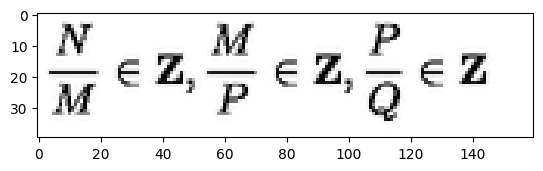

In [7]:
# Access the first sample in the dataset
train_image = dataset_train[0]['image']
 
# Print the corresponding LaTeX text for the first image
print(dataset_train[0]['text'])
 
# Display the image using matplotlib
plt.imshow(train_image)

In [9]:
def convert_to_conversation(sample):
    """
    학습을 위한 message dict 형태로. message 하나에 list 하나.
    """
    instruction = 'Convert the equation images to LaTeX equations.'
    conversation = [
        # User Prompt : 유저의 질문
        { 'role': 'user',
          'content' : [
            {'type' : 'text',  'text'  : instruction},
            {'type' : 'image', 'image' : sample['image']} ]
        },

        # Assistant Response : 모델이 하는 리턴
        { 'role' : 'assistant',
          'content' : [
            {'type' : 'text',  'text'  : sample['text']} ]
        },
    ]
    return { 'messages' : conversation }


In [ ]:
# list of dict를 만듬. 이것도 Trainer에 호환되서 사용가능함
train_dataset = [convert_to_conversation(sample) for sample in tqdm(dataset_train, total=len(dataset_train))]

100%|██████████| 3000/3000 [00:00<00:00, 3277.22it/s]


In [13]:
train_dataset[0]

{'messages': [{'role': 'user',
   'content': [{'type': 'text',
     'text': 'Convert the equation images to LaTeX equations.'},
    {'type': 'image',
     'image': <PIL.PngImagePlugin.PngImageFile image mode=RGB size=160x40>}]},
  {'role': 'assistant',
   'content': [{'type': 'text',
     'text': '{ \\frac { N } { M } } \\in { \\bf Z } , { \\frac { M } { P } } \\in { \\bf Z } , { \\frac { P } { Q } } \\in { \\bf Z }'}]}]}

In [33]:
train_dataset2 = dataset_train.map(convert_to_conversation, remove_columns=dataset_train.column_names, num_proc=8)# num_proc=8) # batched=True은 에러남

In [35]:
train_dataset2[0]

{'messages': [{'content': [{'image': None,
     'text': 'Convert the equation images to LaTeX equations.',
     'type': 'text'},
    {'image': {'bytes': b'\x89PNG\r\n\x1a\n\x00\x00\x00\rIHDR\x00\x00\x00\xa0\x00\x00\x00(\x08\x02\x00\x00\x00\xf6Nf\xcf\x00\x00\x0b\x8cIDATx\x9c\xed[kl\x14\xd5\x17?\xf3\xd8\x9d\x99\xddm\xa7\xd2F\x14\xad\xc2\x07\x8c!\xa0\xec\x07\xb4E\x8aZ$V\xd3\xda\xe2\xa3iH\x90\x18E\xb1\x10\xa1K+"\x01i!\x9a(\xa5\xfa\xc1\x0f\x14\xc5\xf8\xc0`\xe2\xb2\x8b\xad\xd6D]\xb4\xb8\xeb\xb3\xd6DM\x0c\xb4\x15Lc\x8d)\xdb\xees\xde\xf7\xfe?\xdct,\xfb\x10h\xbb\xb3\xfd\x13~\x1f\x9a\xf6\xce\xec\xcco\xcf\xe3\x9es\xcf9\xa50\xc6p\x05\x97/\xd8l\x17L\xc5S\x14\x95\xb22y\xd1b\xa4\xb3\xba\x98K\x16 \xa3\x9f\xe4KJ\xe7q\xb8\xa0\x07#\x84h\x9a\xb6\x86\xcd\x941;I\xce\x06V\x99\x15\x8c\x10\xfa\xf3\xcf?\x05Ap\xb9\\N\xa7\xd3\\\x11E\x91a\x98p8|\xc3\r7XO\x1dc|\xe6\xcc\x19\x8e\xe3\\.\x17\xc7q\x1c\xc7\x99\xeb\x14E\xc5\xe3qM\xd3"\x91\x88\xf5\xdcLb\xa2(\xfe\xf3\xcf?\x08!A\x10\x8a\x8a\x8a\x1c\x0e\x87\x9542"\xb3 TU\xed\

In [36]:
from PIL import Image
def process_vision_info(messages: list[dict]) -> list[Image.Image]:
    """
    데이터셋 이미지를 gemma3에서 처리할 수 있게 RGB 포맷으로 변경
    """
    image_inputs = []
    for msg in messages: # list of dict를 순회
        content = msg.get("content", [])
        if not isinstance(content, list):
            content = [content]
 
        for element in content: # 한 dict (msg)안에서 다시 content를 살펴서 image가 있으면 이를 RGB로 변환해서 append시킴
            if isinstance(element, dict) and ("image" in element or element.get("type") == "image"):
                image = element["image"]
                image_inputs.append(image.convert("RGB"))
    return image_inputs

In [37]:
train_dataset2[0].keys()

dict_keys(['messages'])

In [38]:
process_vision_info(train_dataset2[0]["messages"])

AttributeError: 'NoneType' object has no attribute 'convert'

In [47]:
content = train_dataset2[0]["messages"][0].get("content", [])

In [42]:
if not isinstance(content, list):
    content = [content]

In [44]:
image_inputs = []

In [48]:
type(content)

list

In [49]:
content[0]

{'image': None,
 'text': 'Convert the equation images to LaTeX equations.',
 'type': 'text'}

In [50]:
for element in content: # 한 dict (msg)안에서 다시 content를 살펴서 image가 있으면 이를 RGB로 변환해서 append시킴
    if isinstance(element, dict) and ("image" in element or element.get("type") == "image"):
        image = element["image"]
        image_inputs.append(image.convert("RGB"))

AttributeError: 'NoneType' object has no attribute 'convert'

batched=True 되게끔 시도

In [21]:
import numpy as np
from datasets import Features, Array3D, Sequence, Value

instruction = "Convert the equation images to LaTeX equations."

In [26]:

def convert_batch(batch):
    out = {"messages": []}
    for img, txt in zip(batch["image"], batch["text"]):
        out["messages"].append([
            {"role":"user","content":[
                 {"type":"text","text":instruction},
                 {"type":"image","image":img}        # Image() 그대로 전달
            ]},
            {"role":"assistant","content":[
                 {"type":"text","text":txt}
            ]}
        ])
    return out

In [25]:
from datasets import Features, Sequence, Image, Value

msg_feature = {
    "role": Value("string"),
    "content": Sequence({
        "type": Value("string"),
        "text": Value("string"),
        "image": Image(),           # Image() 타입 사용!
    })
}

features = Features({"messages": Sequence(msg_feature)})


In [27]:
train_dataset2 = dataset_train.cast_column("image", Image())   # 원본도 Image()

In [28]:
train_dataset2 = train_dataset2.map(
    convert_batch,
    remove_columns=train_dataset2.column_names,
    batched=True,
    features=features,
    load_from_cache_file=False,
)

Map:   0%|          | 0/3000 [00:00<?, ? examples/s]

ArrowNotImplementedError: Unsupported cast from list<item: struct<role: string, content: list<item: struct<type: string, text: string, image: struct<bytes: binary, path: string>>>>> to struct using function cast_struct